In [156]:
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import median_filter
import numpy as np
from skimage.morphology import closing, disk
from matplotlib import rc
import torch.nn as nn
from torchvision.utils import save_image
from scipy.ndimage import gaussian_filter
from torchvision import transforms
from scipy.stats import entropy

rc('text', usetex=True)

In [2]:
class UNet(nn.Module):
    
    def __init__(self, channels = 1):
        # Input Size: 1 x 128 x 128
        super().__init__()
        
        self.d1 = nn.Conv2d(channels, 64, 4, 2, 1);
        # Size: 64 x 64 x 64
        
        self.d2 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128)
        )
        # Size: 128 x 32 x 32
        
        self.d3 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256)
        )
        # Size: 256 x 16 x 16
        
        self.d4 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512)
        )
        # Size: 512 x 8 x 8
        
        self.d5 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512)
        )
        # Size: 512 x 4 x 4
        
        self.d6 = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(512, 512, 4, 2, 1),
        )
        
        # Size: 512 x 2 x 2
        
        self.u1 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(512),
        )
        # Size: 512 x 4 x 4
        
        self.u2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512 * 2, 512, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout(0.5)
        )
        
        # Size: 512 x 8 x 8
        self.u3 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(512 * 2, 256, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(256)
        )
        
        # Size: 256 x 16 x 16
        self.u4 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(256 * 2, 128, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(128)
        )
        # Size: 128 x 32 x 32
        
        self.u5 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(128 * 2, 64, kernel_size=4, stride = 2, padding=1),
            nn.BatchNorm2d(64)
        )
        
        # Size: 64 x 64 x 64
        
        self.u6 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64 * 2, 1, kernel_size=4, stride = 2, padding=1),
            nn.Tanh()
        )
        
        # Size: 1 x 128 x 128
    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)
        
        latent_space = self.d6(d5)
        
        u1 = torch.cat((self.u1(latent_space), d5), dim=1)
        u2 = torch.cat((self.u2(u1), d4), dim=1)
        u3 = torch.cat((self.u3(u2), d3), dim=1)
        u4 = torch.cat((self.u4(u3), d2), dim=1)
        u5 = torch.cat((self.u5(u4), d1), dim=1)
    
        return self.u6(u5)
    

In [3]:
# Helper Methods
def normalise(x):
    min_val = torch.min(x)
    max_val = torch.max(x)

    # normalize the tensor
    return (x - min_val) / (max_val - min_val)

def extract_sites_coordinates(segmentation, index):
    return list(zip(*np.where(segmentation[index][0] == 1)))

def swap_tensor(input):
    a, b = input.unique()

    input[input == a] = 2
    input[input == b] = a
    input[input == 2] = b

    return input

In [93]:
# Load data
sites = torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/voronoi-sites_size-128-128_timestep-10.tiff'))

tessellation = torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/voronoi-tessellation_size-128-128_timestep-10.tif')).unsqueeze(dim=1)
real_segmentation = torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/real-segmentation-map_size-128-128_timestep-10.tiff'))
syn_segmentation = torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/gan-segmentation-map_size-128-128_timestep-10.tiff'))

real_cell = normalise(torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/real-cell-images_size-128-128_timestep-10.tiff')))
syn_cell = normalise(torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/gan-cell-image_size-128-128_timestep-10_closed-disk-r3_ridge.tiff')))

In [65]:
G1 = UNet()
G1.load_state_dict(torch.load('./unet-128-pointcloud-to-segmentation-lambda-1000-semiadversarial.pth'))

G2 = UNet()
G2.load_state_dict(torch.load('./unet-128-pointcloud-to-segmentation-lambda-1000-fulladversarial.pth'))

<All keys matched successfully>

In [66]:
maps_G1 = normalise(G1(sites).detach()).numpy()
maps_G2 = normalise(G2(sites).detach()).numpy()

In [73]:
imsave("syn-segmentation-maps-full-adversarial-128.tiff", maps_G2, plugin='tifffile')

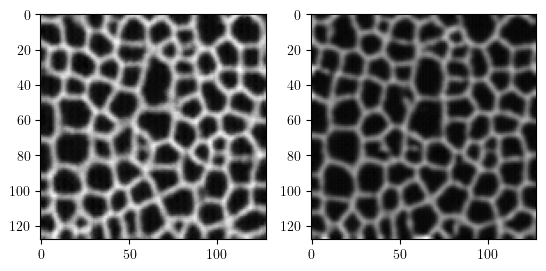

In [64]:
plt.subplot(1,2,1)
plt.imshow(maps_G1[0,0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(maps_G2[0,0], cmap='gray')

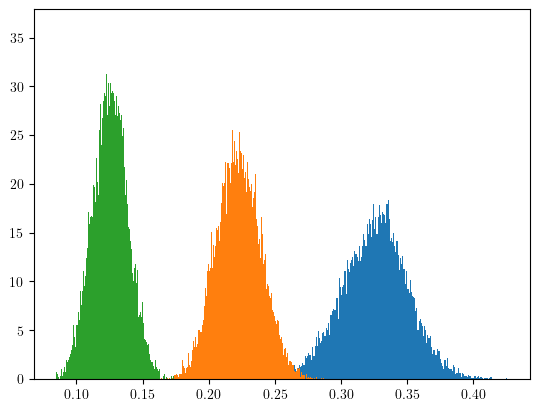

In [167]:
p1, _, _ = plt.hist(np.mean(maps_G1, axis=0).flatten(), 255, density=True)
p2, _, _ = plt.hist(np.mean(maps_G2, axis=0).flatten(), 255, density=True)
p3, _, _ = plt.hist(np.mean(transforms.GaussianBlur(5, 1.5)(real_segmentation).numpy(), axis=0).flatten(), 255, density=True)

In [ ]:
from kornia.metrics import ssim

curr = 27

ssim(real_cell[curr].unsqueeze(dim = 0), syn_cell[curr].unsqueeze(dim = 0), window_size=7).mean()

In [ ]:
# med_filtered = normalise(torch.from_numpy(median_filter(syn_segmentation, size=(1,1,2,2))))
med_filtered = torch.from_numpy(median_filter(syn_segmentation, size=(1,1,2,2)))

In [ ]:
plt.figure(figsize=(15,10))
plt.axis('off')
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(med_filtered[0][0], cmap='gray')
plt.text(64, 135, '(a)', ha='center', fontsize='xx-large')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(ridge_maps[0][0], cmap='gray')
plt.text(64, 135, '(b)', ha='center', fontsize='xx-large')

In [ ]:
closed = med_filtered.clone()

for i in range(closed.shape[0]):
    closed[i] = normalise(torch.Tensor(closing(med_filtered[i][0], disk(2))))



In [ ]:
# Load our ridge detected maps
ridge_maps = swap_tensor(normalise(torch.Tensor(imread('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/processed/gan-segmentation-map_size-128-128_timestep-10_closed-disk-r3_ridge.tif')).unsqueeze(dim=1)))

In [ ]:
plt.figure(figsize=(10,10))

for i in range(1,100):
    plt.subplot(10,10,i)
    plt.axis('off')
    plt.imshow(med_filtered[i][0], cmap='gray')
    plt.imshow(ridge_maps[i][0], alpha=0.35, cmap='gray')

In [ ]:
generator = UNet()
generator.load_state_dict(torch.load('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/unet-voronoi-to-segmentation_128_lambda-1000.pth', map_location=torch.device('cpu')))

In [ ]:
maps = generator(sites).detach().numpy()

In [ ]:
maps.shape
plt.imshow(maps[0][0], cmap='gray')

In [ ]:
res = normalise(generator(ridge_maps).detach())

In [ ]:
plt.imshow(ridge_maps[0][0], cmap='gray')

imsave('/Users/siddharthsrivastava/Library/CloudStorage/OneDrive-UniversityofWarwick/Dissertation Models - Siddharth Srivastava/dataset/gan-cell-image_size-128-128_timestep-10_closed-disk-r3_ridge.tiff', res.numpy(), plugin='tifffile')

In [ ]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(res[0][0], cmap='gray')

plt.subplot(2,2,2)
plt.imshow(ridge_maps[0][0], cmap='gray')

plt.subplot(2,2,3)
plt.imshow(real_cell[0][0], cmap='gray')

plt.subplot(2,2,4)
plt.imshow(real_segmentation[0][0], cmap='gray')